## Instance Segmentation on Bottle dataset using YOLOv11

**Author:Abhishek Dey**

In [4]:
!pip install ultralytics

In [20]:
!rm -rf /kaggle/working/Bottle_Project

### Visualise Sample data

In [14]:
import os
import cv2
import numpy as np
from glob import glob
import random
import matplotlib.pyplot as plt

# Predefined 20 bright & distinct colors (BGR format for OpenCV)
FIXED_COLORS = [
    (255, 0, 0),      # Blue
    (0, 255, 0),      # Green
    (0, 0, 255),      # Red
    (255, 255, 0),    # Cyan
    (255, 0, 255),    # Magenta
    (0, 255, 255),    # Yellow
    (128, 0, 0),      # Dark Blue
    (0, 128, 0),      # Dark Green
    (0, 0, 128),      # Dark Red
    (128, 128, 0),    # Olive
    (128, 0, 128),    # Purple
    (0, 128, 128),    # Teal
    (255, 128, 0),    # Orange
    (128, 255, 0),    # Lime
    (0, 255, 128),    # Aqua Green
    (255, 0, 128),    # Pink
    (128, 0, 255),    # Violet
    (0, 128, 255),    # Sky Blue
    (192, 192, 192),  # Silver
    (0, 0, 0)         # Black (for contrast, rare)
]

def get_fixed_color(idx):
    """Return one of 20 fixed colors, cycling if idx >= 20."""
    return FIXED_COLORS[idx % len(FIXED_COLORS)]

def draw_instance_masks_with_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    overlay = image.copy()
    h, w = image.shape[:2]

    if not os.path.exists(label_path):
        print(f"[!] No label file for {image_path}")
        return image

    boxes_and_labels = []

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        parts = list(map(float, line.strip().split()))
        class_id = int(parts[0])
        coords = parts[1:]

        if len(coords) < 6 or len(coords) % 2 != 0:
            continue

        # Denormalize polygon points
        pts = np.array([[int(x * w), int(y * h)] for x, y in zip(coords[::2], coords[1::2])], np.int32)
        pts = pts.reshape((-1, 1, 2))

        # Pick color from fixed set
        color = get_fixed_color(idx)

        # Draw filled polygon mask
        cv2.fillPoly(overlay, [pts], color=color)

        # Calculate bounding box
        x_min = np.min(pts[:, 0, 0])
        y_min = np.min(pts[:, 0, 1])
        x_max = np.max(pts[:, 0, 0])
        y_max = np.max(pts[:, 0, 1])

        boxes_and_labels.append((x_min, y_min, x_max, y_max, class_id, idx, color))

    # Blend masks with original image
    alpha = 0.8
    blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    # Draw bounding boxes & labels
    for x_min, y_min, x_max, y_max, class_id, idx, color in boxes_and_labels:
        cv2.rectangle(blended, (x_min, y_min), (x_max, y_max), color, 2)
        label = f'ID {idx} | Class {class_id}'
        cv2.putText(blended, label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return blended

def visualize_random_images_subplots(images_dir, labels_dir, n=6, cols=3):
    """
    Display N random images with masks and bboxes in a subplot grid.
    """
    image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
    samples = random.sample(image_paths, min(n, len(image_paths)))

    rows = (n + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, img_path in enumerate(samples):
        file_stem = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_dir, file_stem + ".txt")
        visual = draw_instance_masks_with_boxes(img_path, label_path)
        visual_rgb = cv2.cvtColor(visual, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(visual_rgb)
        plt.axis("off")
        plt.title(file_stem)

    plt.tight_layout()
    plt.show()


## Train Samples

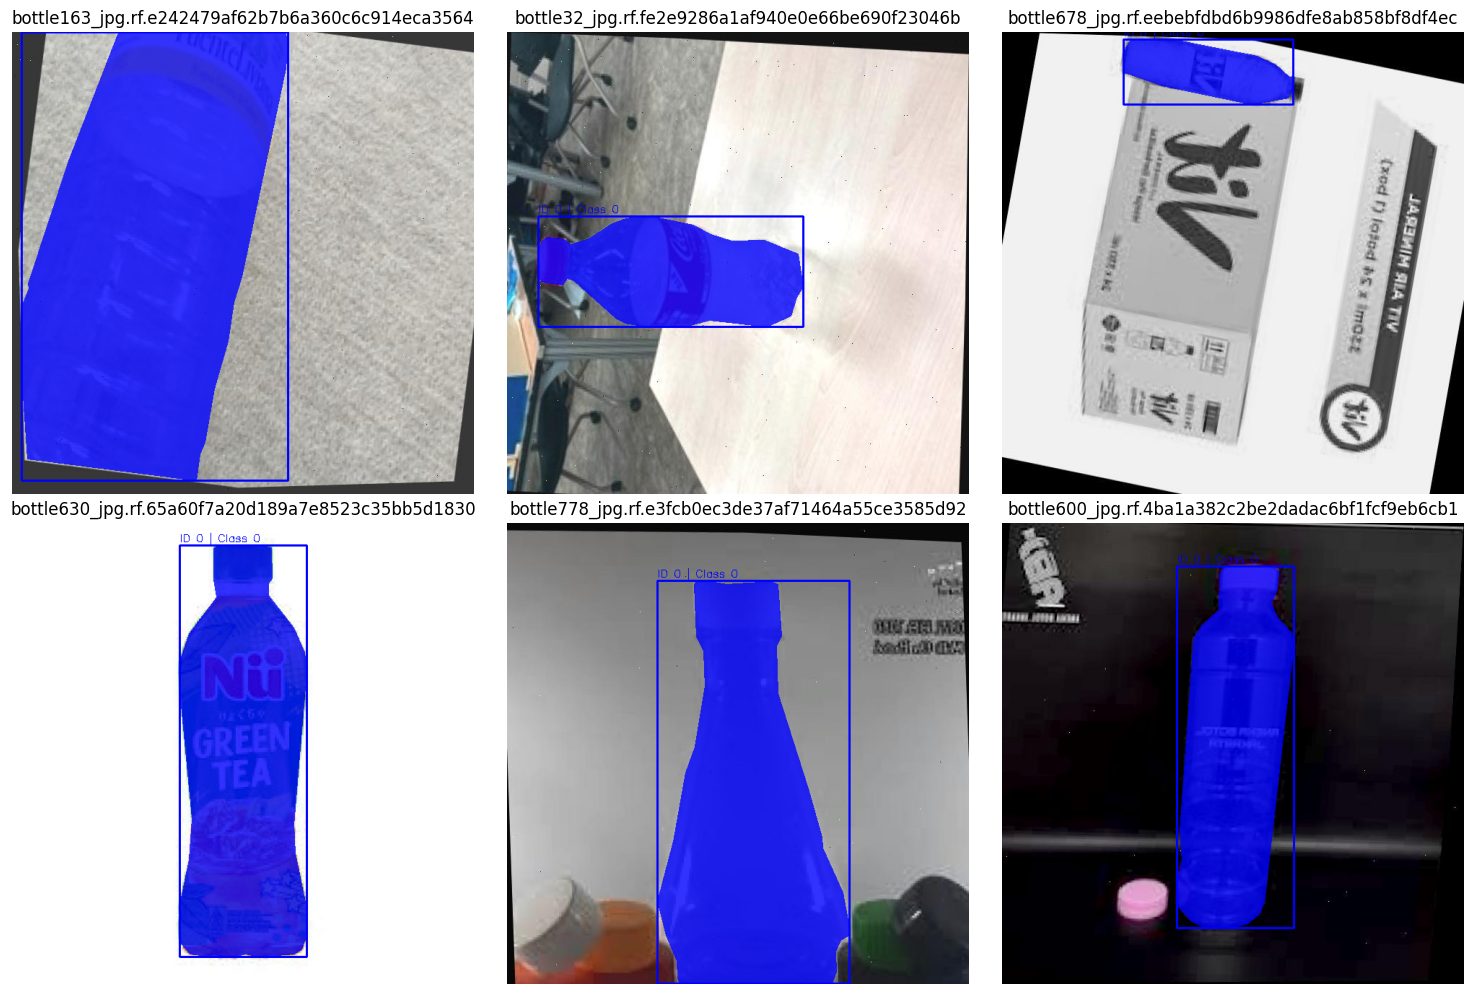

In [16]:

visualize_random_images_subplots(
    images_dir="/kaggle/input/bottle-dataset-roboflow/train/images",
    labels_dir="/kaggle/input/bottle-dataset-roboflow/train/labels",
    n=6,
    cols=3
)

## Validation set

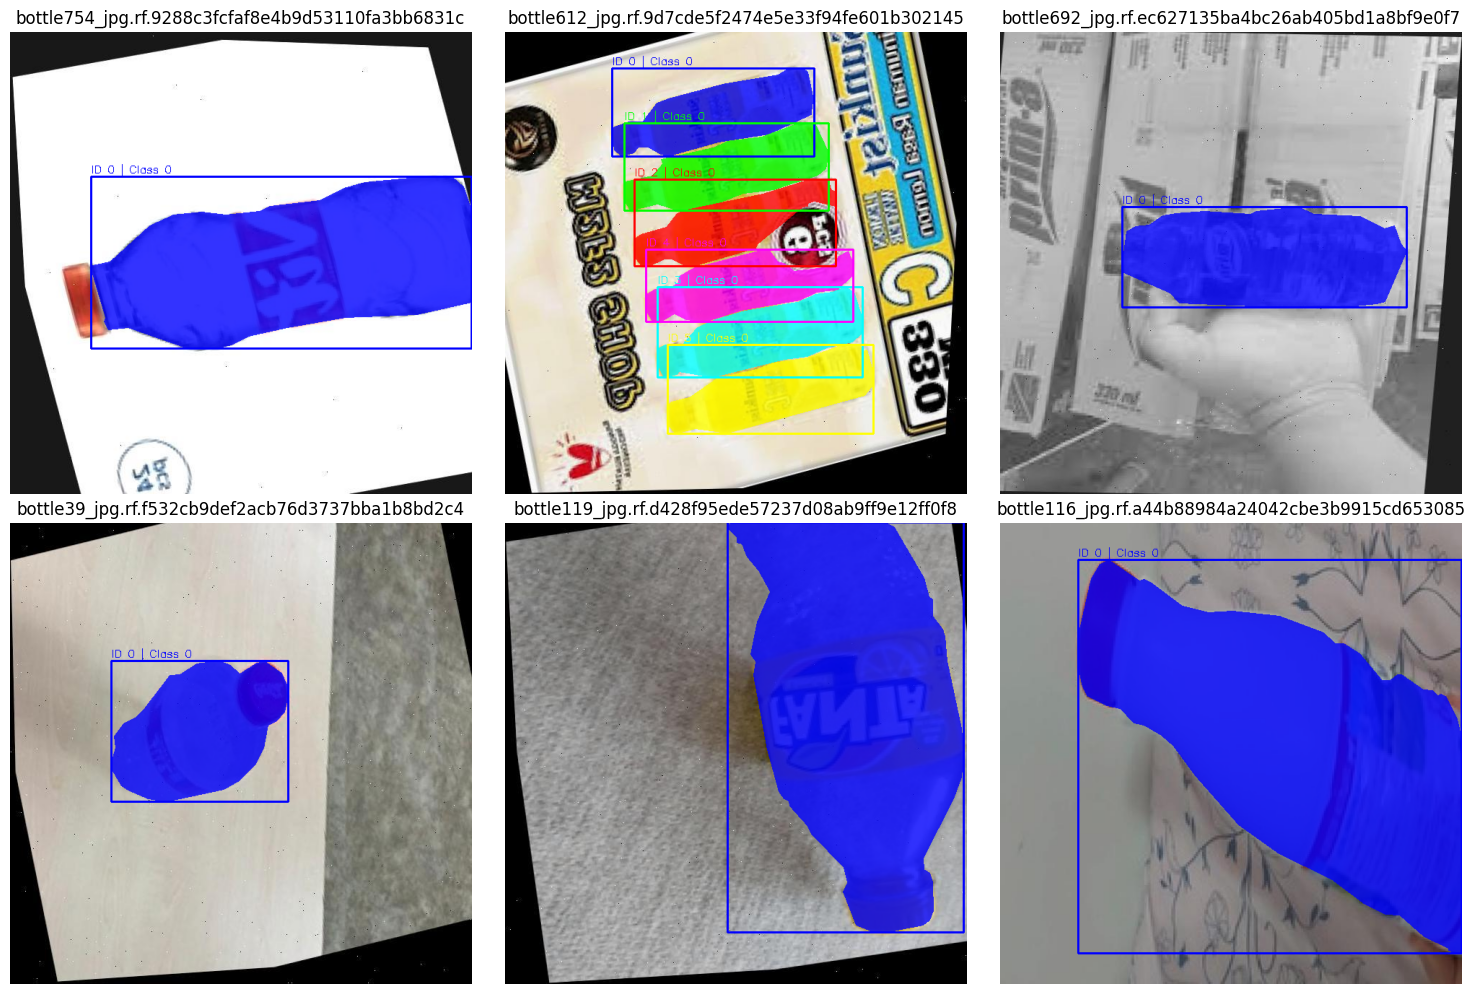

In [17]:
visualize_random_images_subplots(
    images_dir="/kaggle/input/bottle-dataset-roboflow/valid/images",
    labels_dir="/kaggle/input/bottle-dataset-roboflow/valid/labels",
    n=6,
    cols=3
)

## Test Set

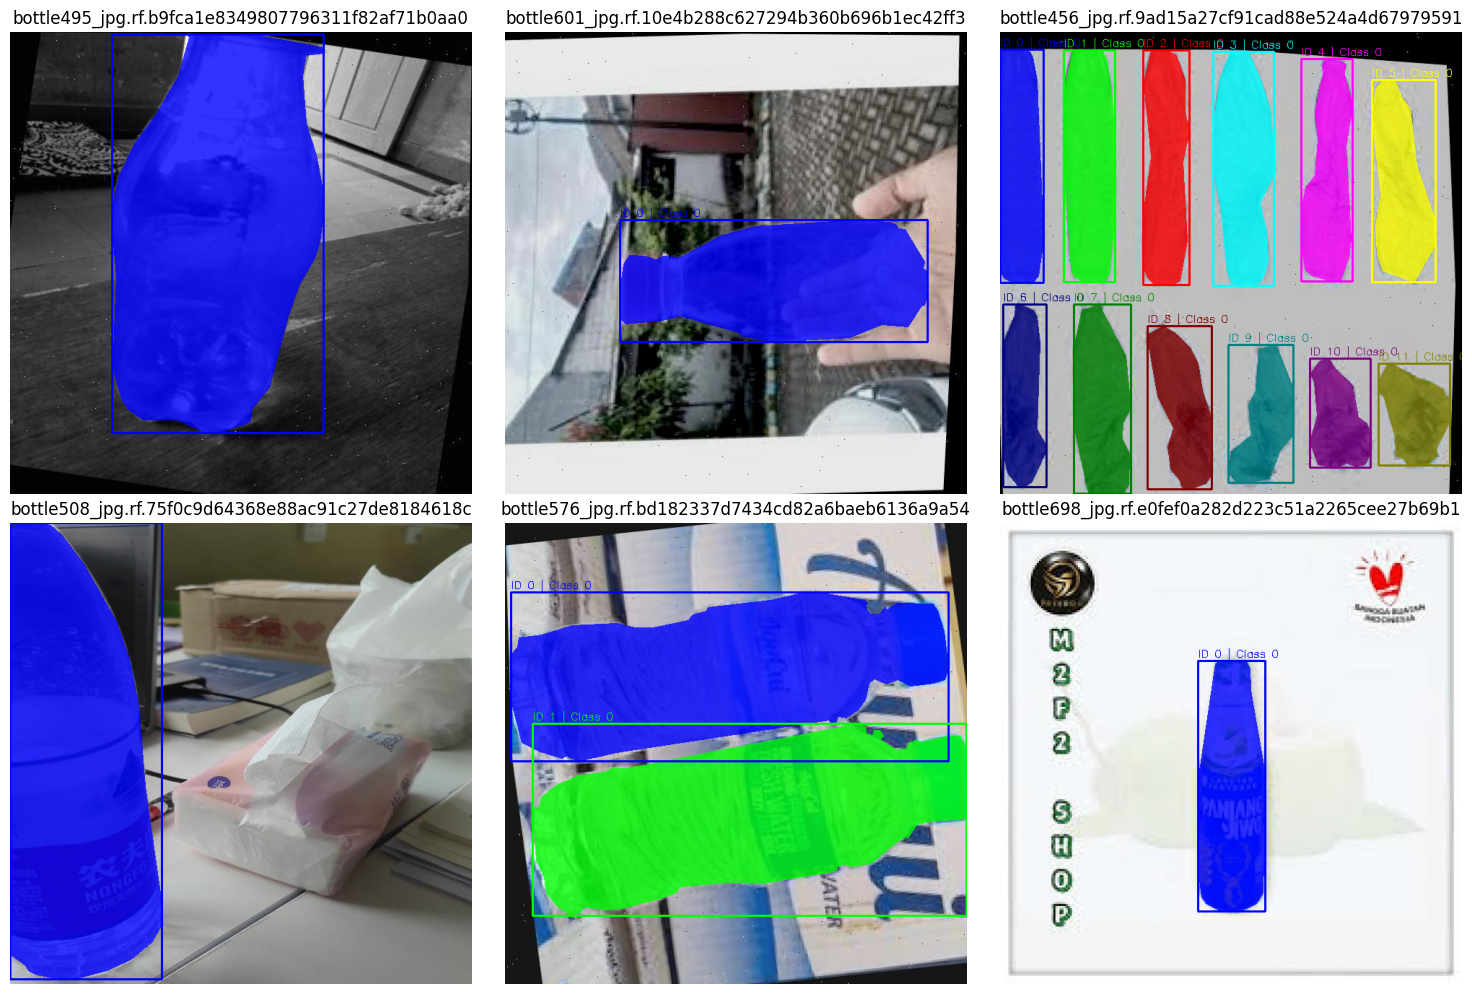

In [18]:
visualize_random_images_subplots(
    images_dir="/kaggle/input/bottle-dataset-roboflow/test/images",
    labels_dir="/kaggle/input/bottle-dataset-roboflow/test/labels",
    n=6,
    cols=3
)

## Model Training

In [19]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO

In [21]:
data="/kaggle/input/bottle-dataset-roboflow/data.yaml"
imgsz=640
epochs=50
batch=12
project="Bottle_Project"
pat=5
opt="Adam"
wk=4
scale=0.8
degrees=180
lr0=0.001

In [22]:
# Load a model
model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

results = model.train(data=data, epochs=epochs, imgsz=imgsz, batch=batch, project=project, patience=pat, optimizer=opt, workers=wk, scale=scale, degrees=degrees, lr0=lr0, multi_scale=True)


Transferred 499/561 items from pretrained weights
Ultralytics 8.3.199 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/bottle-dataset-roboflow/data.yaml, degrees=180, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=True, name=train, nbs=64, nms=False, opset=None, optimize=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        167        239      0.852      0.818      0.886      0.694      0.861      0.826       0.88      0.651
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /kaggle/working/Bottle_Project/train


### Model Evaluation on test set

In [23]:
data="/kaggle/input/bottle-dataset-roboflow/data.yaml"
model="/kaggle/working/Bottle_Project/train/weights/best.pt"
imgsz=640
conf=0.35
iou=0.30
batch=12
project="Bottle_Project"
split="test"
tta=False


# Load a model

model = YOLO(model, task='segment') 

# validation

metrics = model.val(data=data, imgsz=imgsz, batch=batch, save_json=True, conf=conf, iou=iou, rect=False, project=project, split=split, augment=tta)

Ultralytics 8.3.199 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access ✅ (ping: 1.6±1.9 ms, read: 12.0±4.1 MB/s, size: 30.8 KB)
val: Scanning /kaggle/input/bottle-dataset-roboflow/test/labels... 84 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 84/84 303.0it/s 0.3s0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/bottle-dataset-roboflow/test is not writeable, cache not saved.
requirements: Ultralytics requirement ['faster-coco-eval>=1.6.7'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 1.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.8it/s 3.9s0.3ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         84        119      0.956      0.908      0.948      0.794      0.956      0.908      0.948       0.77
Speed: 2.7ms preprocess, 5.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Saving /kaggle/working/Bottle_Project/val/predictions.json...
Results saved to /kaggle/working/Bottle_Project/val


### Confusion matix (val set)

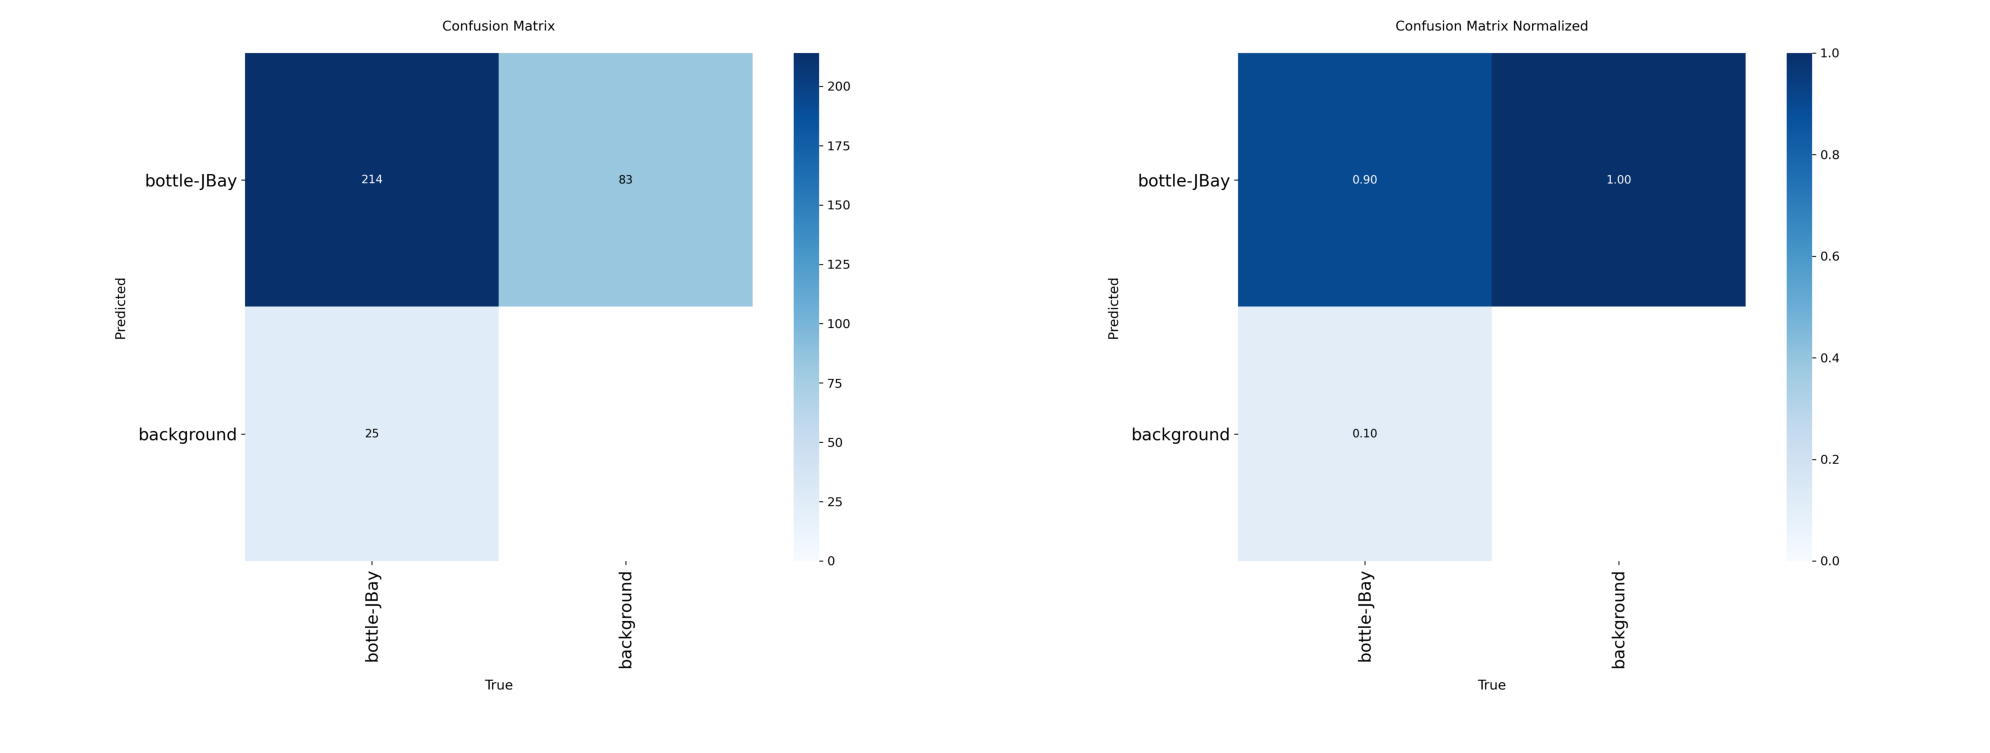

In [25]:

# Paths to your 2 images
img1 = "/kaggle/working/Bottle_Project/train/confusion_matrix.png"
img2 = "/kaggle/working/Bottle_Project/train/confusion_matrix_normalized.png"

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Display each image
axes[0].imshow(mpimg.imread(img1))
axes[0].axis("off")

axes[1].imshow(mpimg.imread(img2))
axes[1].axis("off")


plt.tight_layout()
plt.show()

### Plots - Bounding Box

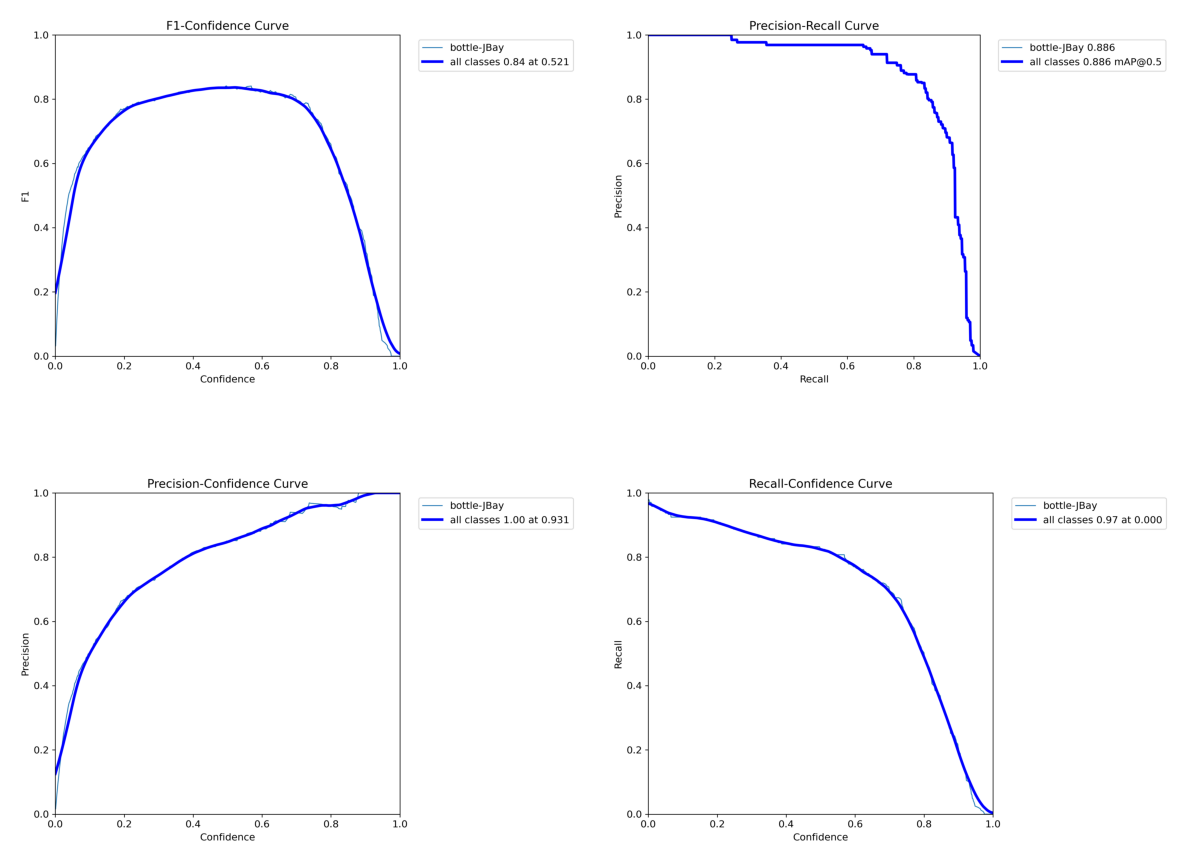

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to your 4 images
img1 = "/kaggle/working/Bottle_Project/train/BoxF1_curve.png"
img2 = "/kaggle/working/Bottle_Project/train/BoxPR_curve.png"
img3 = "/kaggle/working/Bottle_Project/train/BoxP_curve.png"
img4 = "/kaggle/working/Bottle_Project/train/BoxR_curve.png"

# Create subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Display each image
axes[0, 0].imshow(mpimg.imread(img1))
axes[0, 0].axis("off")

axes[0, 1].imshow(mpimg.imread(img2))
axes[0, 1].axis("off")

axes[1, 0].imshow(mpimg.imread(img3))
axes[1, 0].axis("off")

axes[1, 1].imshow(mpimg.imread(img4))
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


### Plots - Masks

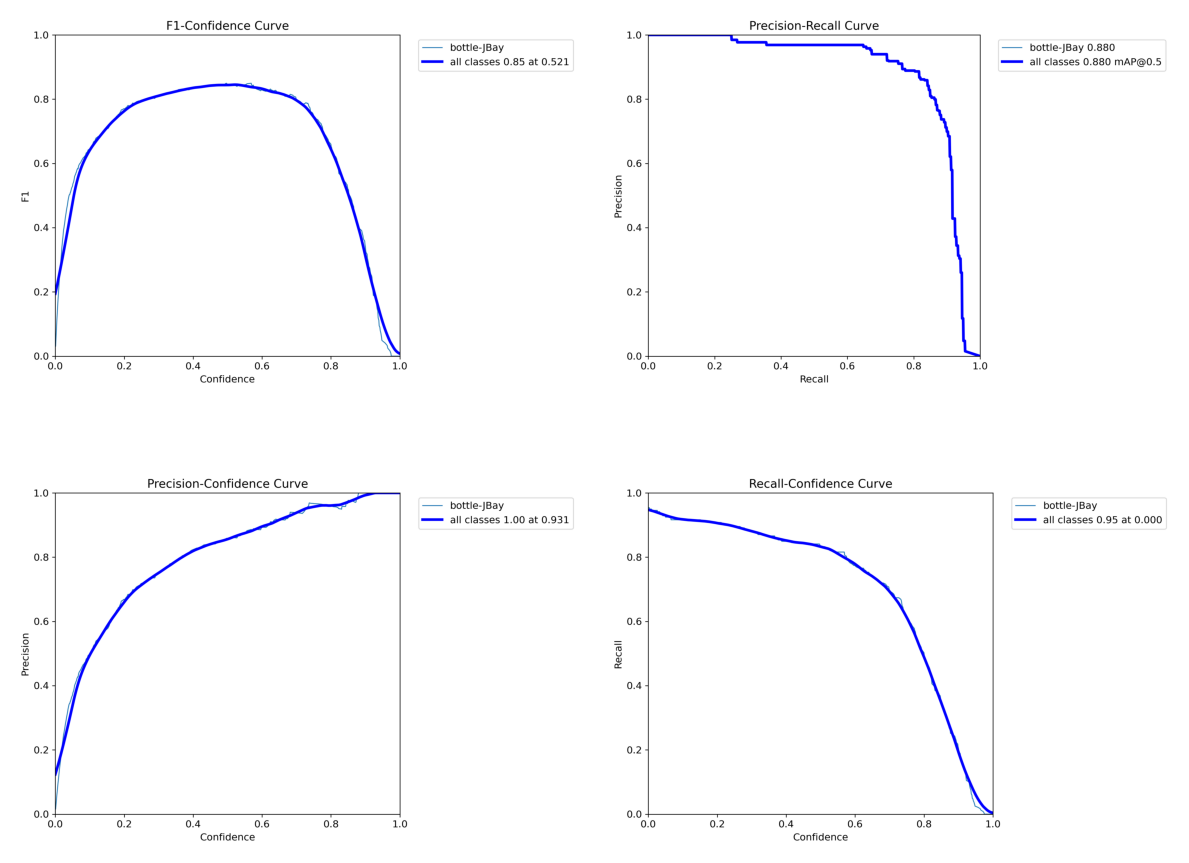

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to your 4 images
img1 = "/kaggle/working/Bottle_Project/train/MaskF1_curve.png"
img2 = "/kaggle/working/Bottle_Project/train/MaskPR_curve.png"
img3 = "/kaggle/working/Bottle_Project/train/MaskP_curve.png"
img4 = "/kaggle/working/Bottle_Project/train/MaskR_curve.png"

# Create subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Display each image
axes[0, 0].imshow(mpimg.imread(img1))
axes[0, 0].axis("off")

axes[0, 1].imshow(mpimg.imread(img2))
axes[0, 1].axis("off")

axes[1, 0].imshow(mpimg.imread(img3))
axes[1, 0].axis("off")

axes[1, 1].imshow(mpimg.imread(img4))
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


## Visualise GT v/s PR

In [36]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from glob import glob
from ultralytics import YOLO

# 20 distinct bright colors
COLORS = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), 
    (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0),
    (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128),
    (255, 128, 0), (128, 255, 0), (0, 255, 128), (0, 128, 255),
    (128, 0, 255), (255, 0, 128), (192, 192, 192), (64, 64, 64)
]

# ------------------------- #
# Draw GT masks + boxes
# ------------------------- #
def draw_gt(image_path, label_path):
    image = cv2.imread(image_path)
    overlay = image.copy()
    h, w = image.shape[:2]

    if not os.path.exists(label_path):
        return image

    with open(label_path, "r") as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        parts = list(map(float, line.strip().split()))
        coords = parts[1:]

        # Skip invalid polygons
        if len(coords) < 6 or len(coords) % 2 != 0:
            continue

        pts = np.array([[int(x * w), int(y * h)] for x, y in zip(coords[::2], coords[1::2])], np.int32)
        pts = pts.reshape((-1, 1, 2))

        color = COLORS[idx % len(COLORS)]
        cv2.fillPoly(overlay, [pts], color=color)

        # bounding box
        x_min, y_min = np.min(pts[:, 0, 0]), np.min(pts[:, 0, 1])
        x_max, y_max = np.max(pts[:, 0, 0]), np.max(pts[:, 0, 1])
        cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # green

    blended = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    return blended

# ------------------------- #
# Draw PR masks + boxes
# ------------------------- #
def draw_pr(image_path, model):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    overlay = image.copy()

    results = model.predict(image_path, verbose=False)
    if not results or len(results[0].masks.xy) == 0:
        return image  # no detections

    for idx, (mask, box) in enumerate(zip(results[0].masks.xy, results[0].boxes.xyxy)):
        pts = np.array(mask, dtype=np.int32).reshape((-1, 1, 2))
        color = COLORS[idx % len(COLORS)]
        cv2.fillPoly(overlay, [pts], color=color)

        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # red

    blended = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    return blended

# ------------------------- #
# Visualize GT vs PR
# ------------------------- #
def visualize_gt_vs_pr(images_dir, gt_labels_dir, model_path, n=4):
    model = YOLO(model_path)  # load trained model
    image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
    samples = random.sample(image_paths, min(n, len(image_paths)))

    plt.figure(figsize=(10, 5 * n))

    for i, img_path in enumerate(samples):
        file_stem = os.path.splitext(os.path.basename(img_path))[0]
        gt_label_path = os.path.join(gt_labels_dir, file_stem + ".txt")

        gt_visual = draw_gt(img_path, gt_label_path)
        pr_visual = draw_pr(img_path, model)

        gt_rgb = cv2.cvtColor(gt_visual, cv2.COLOR_BGR2RGB)
        pr_rgb = cv2.cvtColor(pr_visual, cv2.COLOR_BGR2RGB)

        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(gt_rgb)
        plt.axis("off")
        plt.title("Ground Truth")

        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(pr_rgb)
        plt.axis("off")
        plt.title("Prediction")

    plt.tight_layout()
    plt.show()


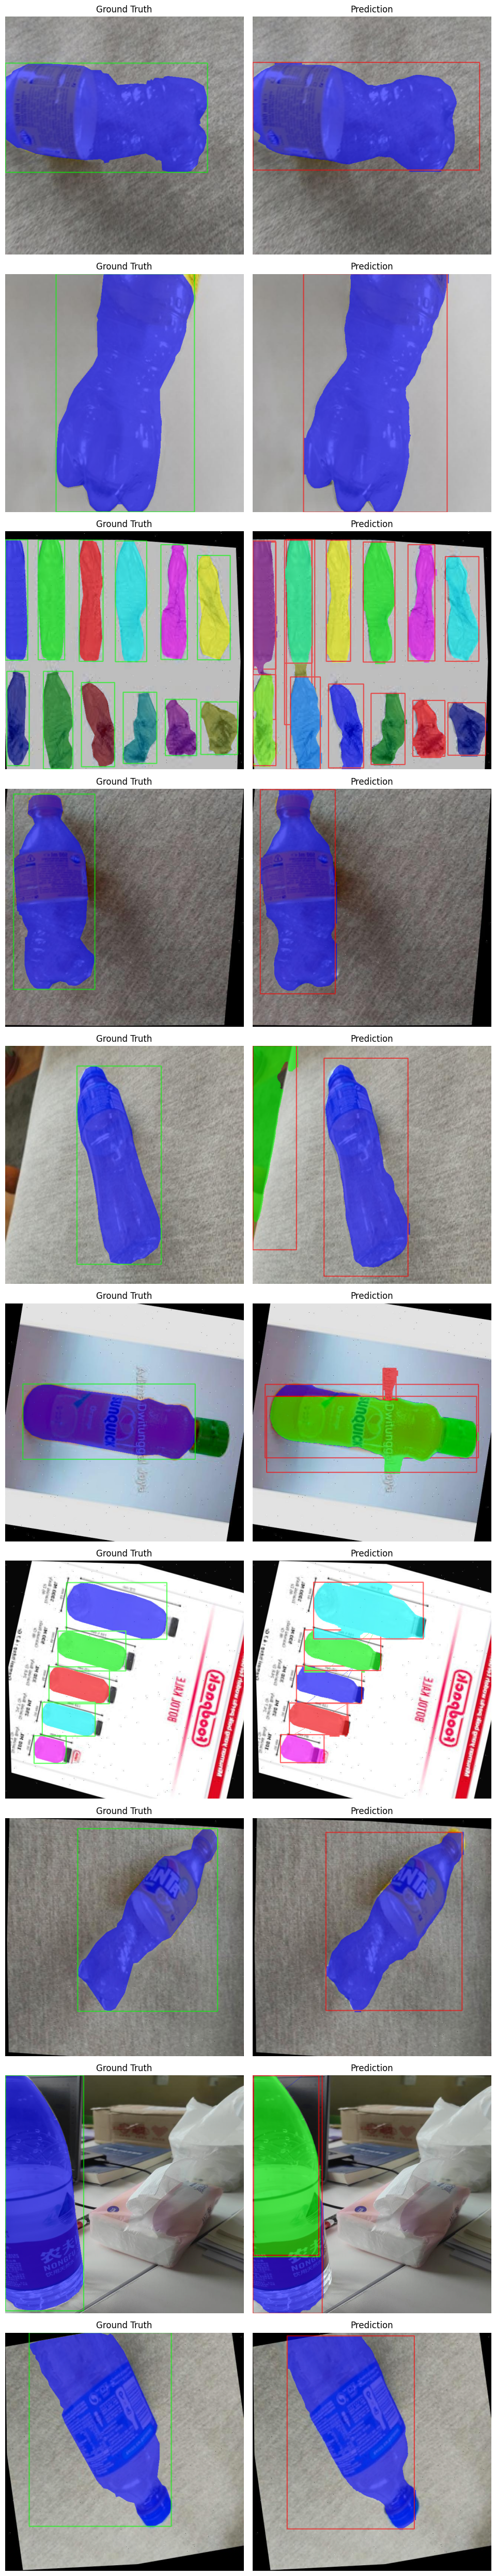

In [37]:

visualize_gt_vs_pr(
    images_dir="/kaggle/input/bottle-dataset-roboflow/test/images",
    gt_labels_dir="/kaggle/input/bottle-dataset-roboflow/test/labels",
    model_path="/kaggle/working/Bottle_Project/train/weights/best.pt",
    n=10
)
